In [1]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113  # cuda 11.3 version 다운로드

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113


In [2]:
%%sh

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-3yy05gwa
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265172 sha256=6fc6595e0a951d209d376fc0f254e5728350c2e4aa59d761104ab14c0347bc66
  Stored in directory: /tmp/pip-ephem-wheel-cache-xhpsp34g/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.5
    Uninstalling pycocotools-2.0.5:
      Successfully uninstalled pycocotools-2.0.5


  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-3yy05gwa


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
cd drive/MyDrive/Colab Notebooks/X:AI

/content/drive/MyDrive/Colab Notebooks/X:AI


In [6]:
# 드라이브에 마운트해서 데이터셋 압축 해제
!unzip -qq "aquarium.zip"

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [7]:
!pip install pycocotools
!pip install albumentations  # 이미지를 손쉽게 augmentation 해주는 python 라이브러리

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from pycocotools.coco import COCO
import torch
import os
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2  # OpenCV은 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# 경고창 제거
import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm 
from torchvision.utils import draw_bounding_boxes

In [10]:
print(torch.__version__)
print(torchvision.__version__)

1.12.1+cu113
0.13.1+cu113


In [11]:
import albumentations.pytorch

In [12]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(512, 512), # input size : 600px
            A.HorizontalFlip(p=0.3),  # 0.3의 확률로 좌우 반전
            A.VerticalFlip(p=0.3),  # 0.3의 확률로 상하 반전
            A.RandomBrightnessContrast(p=0.1),  # 0.1의 확률로 밝기 대비
            albumentations.pytorch.transforms.ToTensorV2()  # Albummentations에 ToTensor는 더 이상 사용되지 않으며 대신 ToTensorV2를 사용
        ], bbox_params=A.BboxParams(format='coco'))  # BboxParams에 대한 좌표 형식 및 몇 가지 다른 매개변수를 지정
        # 자세한 설명 : https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    else:
        transform = A.Compose([
            A.Resize(512, 512),
            albumentations.pytorch.transforms.ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [13]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # datasets.VisionDataset를 위해 3가지 transform 파라미터가 필요
        super().__init__(root, transforms, transform, target_transform)
        self.split = split # train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn이 저장될 곳
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]  # target이 1개 이상일 경우만 선정
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target]  # albumentations을 위해 필요한 annotation 구조
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # xywh를 xyxy로 변경
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # 필요한 target 구조 바꾸어 주기
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) 
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ  # images scale변환
    
    def __len__(self):
        return len(self.ids)

In [14]:
dataset_path = 'Aquarium Combined/'  # root 경로

In [15]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [16]:
classes = [i[1]['name'] for i in categories.items()]
classes

# 생물, 물고기, 해파리, 펭귄, 퍼핀, 상어, 불가사리, 가오리

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [17]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))
valid_dataset = AquariumDetection(root=dataset_path, split='valid', transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


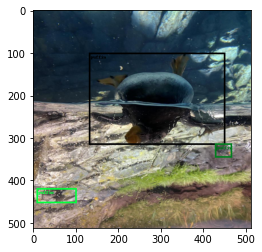

In [18]:
# sample image 확인

sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)

plt.imshow(draw_bounding_boxes(  # torchvision.utils 안에 있는 라이브러리
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [19]:
len(train_dataset)

447

### Model

In [20]:
# faster rcnn model 로딩
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))  # batch로 묶기 위한 단계

# 자세한 설명 : https://hulk89.github.io/pytorch/2019/09/30/pytorch_dataset/

In [22]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [23]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [24]:
device = torch.device("cuda") 

In [25]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [26]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1)

In [27]:
import sys

### Train

In [28]:
%%sh

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
error: Your local changes to the following files would be overwritten by checkout:
	.circleci/build_docs/commit_docs.sh
	.circleci/regenerate.py
	.circleci/unittest/android/scripts/install_gradle.sh
	.circleci/unittest/ios/scripts/binary_ios_build.sh
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run-clang-format.py
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	android/gradlew
	ios/VisionTestApp/clean.sh
	ios/VisionTestApp/setup.sh
	ios/build_ios.sh
	packaging/build_cmake.sh
	packaging/build_conda.sh
	packaging/build_wheel.sh
	scripts/fbcode_to_main_sync.sh
Please commit your changes or stash them before you switch branches.
Aborting


In [37]:
from torch.optim.lr_scheduler import StepLR
from engine import train_one_epoch, evaluate

num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    # evaluate(model, valid_loader, device=device)

Epoch: [0]  [  0/112]  eta: 0:01:35  lr: 0.000075  loss: 0.4865 (0.4865)  loss_classifier: 0.1607 (0.1607)  loss_box_reg: 0.3150 (0.3150)  loss_objectness: 0.0035 (0.0035)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 0.8559  data: 0.5645  max mem: 1141
Epoch: [0]  [ 10/112]  eta: 0:00:24  lr: 0.000748  loss: 0.6349 (0.5777)  loss_classifier: 0.2091 (0.1956)  loss_box_reg: 0.3514 (0.3421)  loss_objectness: 0.0185 (0.0216)  loss_rpn_box_reg: 0.0158 (0.0185)  time: 0.2413  data: 0.0669  max mem: 1141
Epoch: [0]  [ 20/112]  eta: 0:00:23  lr: 0.001421  loss: 0.5589 (0.5581)  loss_classifier: 0.1825 (0.1879)  loss_box_reg: 0.3413 (0.3365)  loss_objectness: 0.0149 (0.0179)  loss_rpn_box_reg: 0.0127 (0.0158)  time: 0.2226  data: 0.0345  max mem: 1141
Epoch: [0]  [ 30/112]  eta: 0:00:20  lr: 0.002094  loss: 0.5281 (0.5485)  loss_classifier: 0.1771 (0.1858)  loss_box_reg: 0.3227 (0.3327)  loss_objectness: 0.0122 (0.0160)  loss_rpn_box_reg: 0.0105 (0.0140)  time: 0.2516  data: 0.0466  max mem: 1141


In [30]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [31]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [32]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

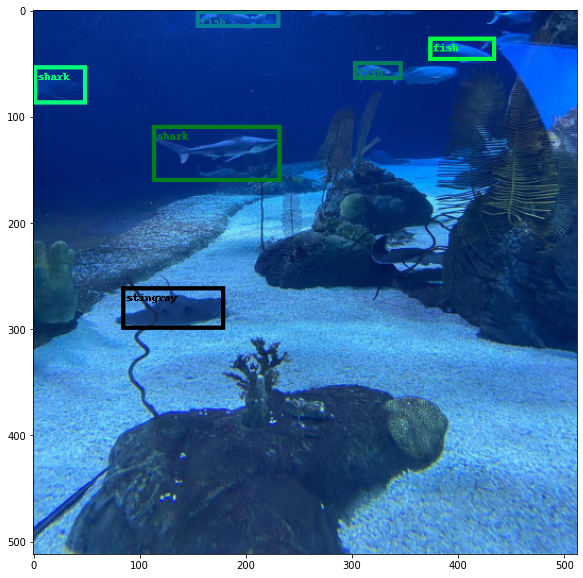

In [33]:
fig = plt.figure(figsize=(14, 10))

plt.imshow(draw_bounding_boxes(img_int, pred['boxes'][pred['scores'] > 0.8],  # prediciton score가 0.8이상인 것 인덱싱
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4).permute(1, 2, 0))